# **Neural network part of Qimpact project**
**Data was proceeded and prepared for NN in Qimpact.jpynb, here's the implementation of NN itself**

In [93]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.profiler import Profiler, AdvancedProfiler
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
from PIL import Image
%matplotlib ipympl
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline
import math
import sys

#!!!
import scienceplots
path='C:/Users/aleks/Projects/arameic-mishmash/Bachelor/Data'
plt.style.use('science')
#!!!

**Size of test and validation data (Rest will be used for training)**

In [50]:
validationsize=1000 #how many samples will be used as traindata
testsize=1000

**Importing already scaled data, that were created in Qimpact.jupynb**

In [51]:
scaled_Qdata = pd.read_csv(f'{path}/scaled_QData_gradT.csv', header=0, index_col=0)  #qdata
print(scaled_Qdata.shape)
scaled_Qdata.head()

(9731, 1353)


,Z_0,Z_1,Z_2,Z_3,Z_4,Z_5,Z_6,Z_7,Z_8,Z_9,...,n_263,n_264,n_265,n_266,n_267,n_268,n_269,Qimpact_c-1,Qimpact_c,Qimpact_c+1
0.003694,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,...,-0.387512,-0.387510,-0.387508,-0.387506,-0.387503,-0.387501,-0.387499,-1.063465,-1.063306,-1.063147
0.003712,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,...,-0.387510,-0.387508,-0.387506,-0.387503,-0.387501,-0.387499,-0.387497,-1.063306,-1.063147,-1.062988
0.003731,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,...,-0.387508,-0.387506,-0.387503,-0.387501,-0.387499,-0.387497,-0.387495,-1.063147,-1.062988,-1.062829
0.003750,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,...,-0.387506,-0.387503,-0.387501,-0.387499,-0.387497,-0.387495,-0.387493,-1.062988,-1.062829,-1.062670
0.003768,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,...,-0.387503,-0.387501,-0.387499,-0.387497,-0.387495,-0.387493,-0.387491,-1.062829,-1.062670,-1.062511


**Shuffling and spliting data**

In [52]:
scaled_Qdata.shape

(9731, 1353)

In [53]:
shuffled_Qdata=scaled_Qdata.sample(n=scaled_Qdata.shape[0])

validation_data=shuffled_Qdata.iloc[:validationsize]
test_data=scaled_Qdata
train_data=shuffled_Qdata.iloc[validationsize+testsize:]

print('Training dataset size: ', train_data.shape, '\nTesting dataset size: ',test_data.shape,'\nValidation dataset size: ', validation_data.shape)

Training dataset size:  (7731, 1353) 
Testing dataset size:  (9731, 1353) 
Validation dataset size:  (1000, 1353)


In [54]:
train_data.head()

,Z_0,Z_1,Z_2,Z_3,Z_4,Z_5,Z_6,Z_7,Z_8,Z_9,...,n_263,n_264,n_265,n_266,n_267,n_268,n_269,Qimpact_c-1,Qimpact_c,Qimpact_c+1
0.073819,-0.390938,-0.390938,-0.390938,-0.390938,-0.390938,-0.390938,-0.390938,-0.390938,-0.390938,-0.390938,...,-0.366730,-0.366724,-0.366719,-0.366714,-0.366708,-0.366703,-0.366698,-0.405012,-0.404798,-0.404584
0.160194,-0.390941,-0.390941,-0.390941,-0.390941,-0.390941,-0.390941,-0.390941,-0.390941,-0.390941,-0.390941,...,-0.184084,-0.180556,-0.176997,-0.173407,-0.169786,-0.166135,-0.162454,2.279241,2.280782,2.282322
0.179698,2.617405,2.617370,2.617334,2.617298,2.617263,2.617228,2.617193,2.617159,2.617125,2.617091,...,2.769202,2.771723,2.774271,2.776845,2.779446,2.782074,2.784728,-0.833537,-0.834368,-0.835197
0.081186,-0.390938,-0.390938,-0.390938,-0.390938,-0.390938,-0.390938,-0.390938,-0.390938,-0.390938,-0.390938,...,-0.364687,-0.364682,-0.364677,-0.364672,-0.364667,-0.364662,-0.364657,-0.317115,-0.316882,-0.316650
0.027873,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,...,-0.382131,-0.382126,-0.382120,-0.382115,-0.382110,-0.382104,-0.382099,-0.854731,-0.854566,-0.854400


In [55]:
target_fields = ['Qimpact_c-1','Qimpact_c','Qimpact_c+1']

train_features, train_targets = train_data.drop(target_fields, axis=1), train_data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]
validation_features, validation_targets = validation_data.drop(target_fields, axis=1), validation_data[target_fields]    


In [68]:
l_rate = 0.02
mse_loss = nn.MSELoss(reduction = 'mean')

In [69]:
train_features.shape[1]

1350

In [143]:
class Regression_3l(pl.LightningModule):
    
### The Model ### 

    # Question: what will your model architecture look like?
    # Initialize the layers
    # Here we have one input layer (size 56 #3N as we have 56 #3N features), one hidden layer (size 10), 
    # and one output layer (size 1 as we are predicting a single value)
    def __init__(self):
        super(Regression_3l, self).__init__()
        self.fc1 = nn.Linear(train_features.shape[1], 20) #Here I changed initial 56 size of fc1 to 1350=#features in 
        self.fc2 = nn.Linear(20, 20) #Here I changed initial 56 size of fc1 to 1350=#features in 
        self.fc3 = nn.Linear(20, 3) #here i changed output size to 3 (as we have 3 target values)
    

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

### Data loader ### 
    def train_dataloader(self):
        train_dataset = TensorDataset(torch.tensor(train_features.values).float(), torch.tensor(train_targets[target_fields].values).float())
        train_loader = DataLoader(dataset = train_dataset, batch_size = 128)
        return train_loader
        
    def val_dataloader(self):
        validation_dataset = TensorDataset(torch.tensor(validation_features.values).float(),\
                                           torch.tensor(validation_targets[target_fields].values).float())
        validation_loader = DataLoader(dataset = validation_dataset, batch_size = 128)
        return validation_loader
    
    def test_dataloader(self):
        test_dataset = TensorDataset(torch.tensor(test_features.values).float(), torch.tensor(test_targets[target_fields].values).float())
        test_loader = DataLoader(dataset = test_dataset, batch_size = 128)
        return test_loader

### The Optimizer ### 
    def configure_optimizers(self):
        return optim.SGD(self.parameters(), lr=l_rate)

### Training ### 
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = mse_loss(logits, y)
        # Add logging
        logs = {'loss': loss}
        return {'loss': loss, 'log': logs}

### Validation ### 
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = mse_loss(logits, y)
        return {'val_loss': loss}

    # Define validation epoch end
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

### Testing ###     
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = mse_loss(logits, y)
        correct = torch.sum(logits == y.data)
        
        predictions_pred.append(logits)
        predictions_actual.append(y.data)
        return {'test_loss': loss, 'test_correct': correct, 'logits': logits}
    
    # Define test end
    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        logs = {'test_loss': avg_loss}      
        return {'avg_test_loss': avg_loss, 'log': logs, 'progress_bar': logs }

In [144]:
model = Regression_3l()
trainer = Trainer(max_epochs = 200)  # Option to check if it's working at all: fast_dev_run=True 
                                    # Option to implement early stopping: early_stop_callback=True
trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type   | Params
--------------------------------
0 | fc1  | Linear | 27.0 K
1 | fc2  | Linear | 420   
2 | fc3  | Linear | 63    
--------------------------------
27.5 K    Trainable params
0         Non-trainable params
27.5 K    Total params
0.110     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\aleks\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\aleks\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


In [145]:
predictions_pred = []
predictions_actual = []
trainer.test()

C:\Users\aleks\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:1386: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at C:\Users\aleks\Projects\arameic-mishmash\Bachelor\Fit tasks\lightning_logs\version_43\checkpoints\epoch=199-step=12200.ckpt
Loaded model weights from checkpoint at C:\Users\aleks\Projects\arameic-mishmash\Bachelor\Fit tasks\lightning_logs\version_43\checkpoints\epoch=199-step=12200.ckpt
C:\Users\aleks\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (tr

Testing: 0it [00:00, ?it/s]

[{}]

In [146]:
torch.save(model.state_dict(), f'{path}/model.pt')
model.eval()

Regression_3l(
  (fc1): Linear(in_features=1350, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=3, bias=True)
)

In [147]:
print('length of pred_actual',len(predictions_actual),'\nsize of tenzors inside pred_actual',predictions_actual[3].size())

length of pred_actual 77 
size of tenzors inside pred_actual torch.Size([128, 3])


In [148]:
# convert my predicted values back to actual numbers of bike rides again, instead of the scaled values used to predict on
data_scaling=pd.read_csv(f'{path}/data_scaling.csv', header=0, index_col=0)
mean = data_scaling['Qimpact'][0]
std = data_scaling['Qimpact'][1]

In [149]:
data_scaling

,Z,T,Kn,n,Qimpact
mean,6.636804,2205.480397,-0.021059,1.121635e+21,2.712235e+13
std,11.862872,688.061478,0.051320,1.691621e+21,2.477510e+13


## Ploting part

In [150]:
figuresize=6.5
import matplotlib.font_manager as fm
mpl.rcParams['font.family'] = 'Avenir'
plt.rcParams['axes.linewidth'] = 0.5

In [151]:
# Get dates for plotting
datesx = scaled_Qdata.index

# Get predicted points (scaled back to their original size)
plot_pred = []
for i in range(len(predictions_pred)):
    plot_pred.extend(predictions_pred[i].T.numpy()[0] * std + mean)

# Get actual points (scaled back to their original size)
plot_actual = []
for i in range(len(predictions_actual)):
    plot_actual.extend(predictions_actual[i].T.numpy()[0] * std + mean)   

**Predicted heat flux**

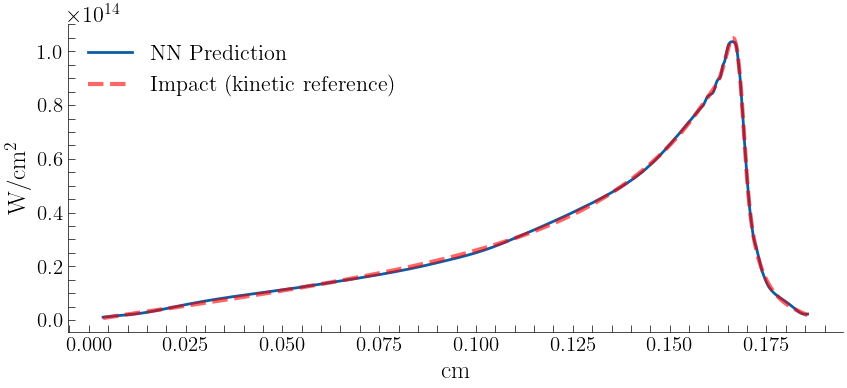

In [152]:
# And finally we can see that our network has done a decent job of estimating!
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(scaled_Qdata.index,plot_pred, label='NN Prediction', lw=2)
ax.plot(scaled_Qdata.index,plot_actual,'r--', label='Impact (kinetic reference)', lw=3, alpha=0.6)
ax.set_xlabel('cm',fontsize=18)
ax.set_ylabel('W/cm$^2$',fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.grid(color='grey', linestyle='-.', linewidth=0.3,which="both")
ax.tick_params(axis='x',which='both',bottom=True,top=False,labelbottom=True, labelsize=15, size=5)
ax.tick_params(axis='y',which='both',left=True,right=False, labelsize=15, size=5)
ax.legend()

**Gradients of predicted heat flux and initial data**

In [153]:
gradQpred=np.gradient(plot_pred, scaled_Qdata.index)
gradQact=np.gradient(plot_actual, scaled_Qdata.index)

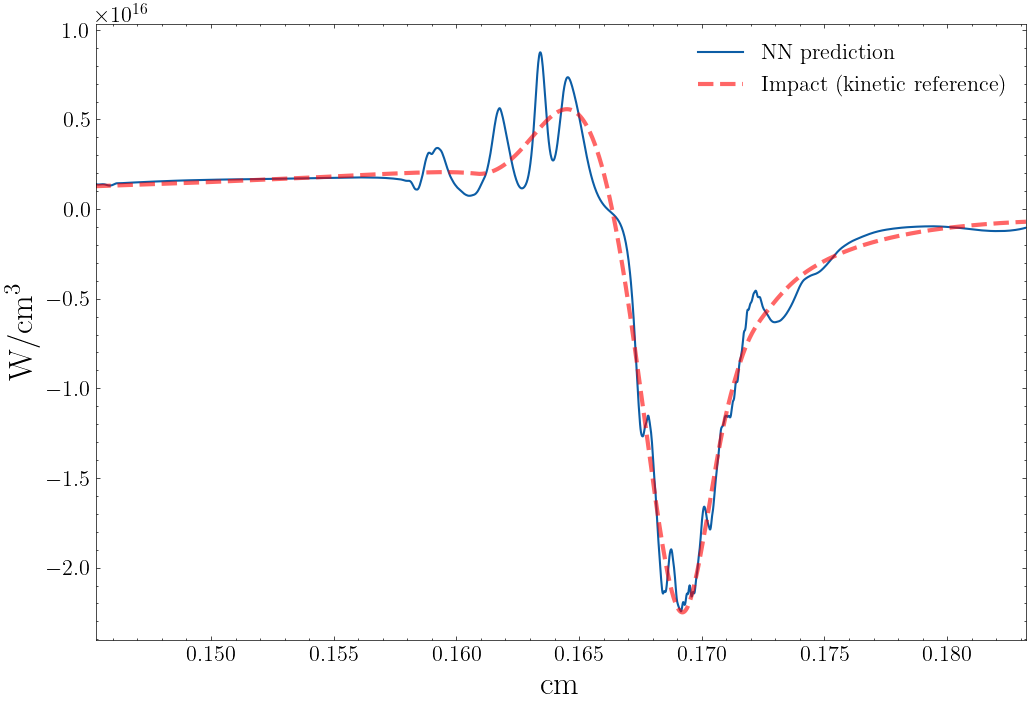

In [154]:
fig2, ax2 = plt.subplots(figsize=(12,8))
ax2.plot(scaled_Qdata.index,gradQpred, label=r'NN prediction', lw=1.5)
ax2.plot(scaled_Qdata.index,gradQact, 'r--', label='Impact (kinetic reference)', lw=3, alpha=0.6)
ax2.set_xlim(1.453e-1,1.832e-1)

ax2.set_xlabel('cm', fontsize=24)
ax2.set_ylabel('W/cm$^3$', fontsize=24)
ax.tick_params(axis='x',which='both',bottom=True,top=False,labelbottom=True, labelsize=15, size=5)
ax.tick_params(axis='y',which='both',left=True,right=False, labelsize=15, size=5)
ax2.legend()


C:\Users\aleks\AppData\Local\Temp\ipykernel_2724\812428851.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig1, axs1 = plt.subplots(2, 1, figsize=(6.5,6.5), sharex=True)


Text(0.5, 0, 'cm')

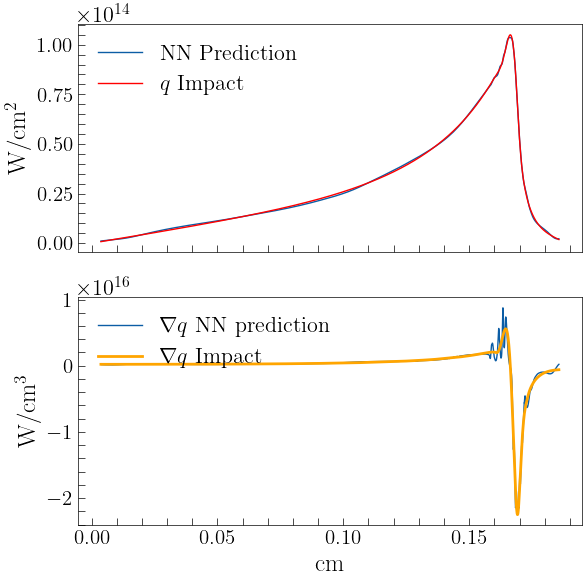

In [155]:
fig1, axs1 = plt.subplots(2, 1, figsize=(6.5,6.5), sharex=True)


axs1[0].plot(scaled_Qdata.index,plot_pred, label='NN Prediction')
axs1[0].plot(scaled_Qdata.index,plot_actual, label='$q$ Impact', color='r')
axs1[0].set_ylabel('W/cm$^2$',fontsize=18)

axs1[0].tick_params(axis='x',which='both',bottom=True,top=False,labelbottom=False, labelsize=15, size=5)
axs1[0].tick_params(axis='y',which='both',left=True,right=False, labelsize=15, size=5)
axs1[1].tick_params(axis='x',which='both',bottom=True,top=False,labelbottom=True, labelsize=15, size=5)
axs1[1].tick_params(axis='y',which='both',left=True,right=False, labelsize=15, size=5)
axs1[0].legend()

axs1[1].plot(scaled_Qdata.index,gradQpred, label=r'$\nabla q$ NN prediction')
axs1[1].plot(scaled_Qdata.index,gradQact, label=r'$\nabla q$ Impact ', color='orange', lw=2)
axs1[1].set_ylabel('W/cm$^3$',fontsize=18)
axs1[1].legend(loc='upper left')
axs1[1].set_xlabel('cm',fontsize=18)


Flux limiter from Qeff profile flim = 1.6e-01 ± 7.4e-04


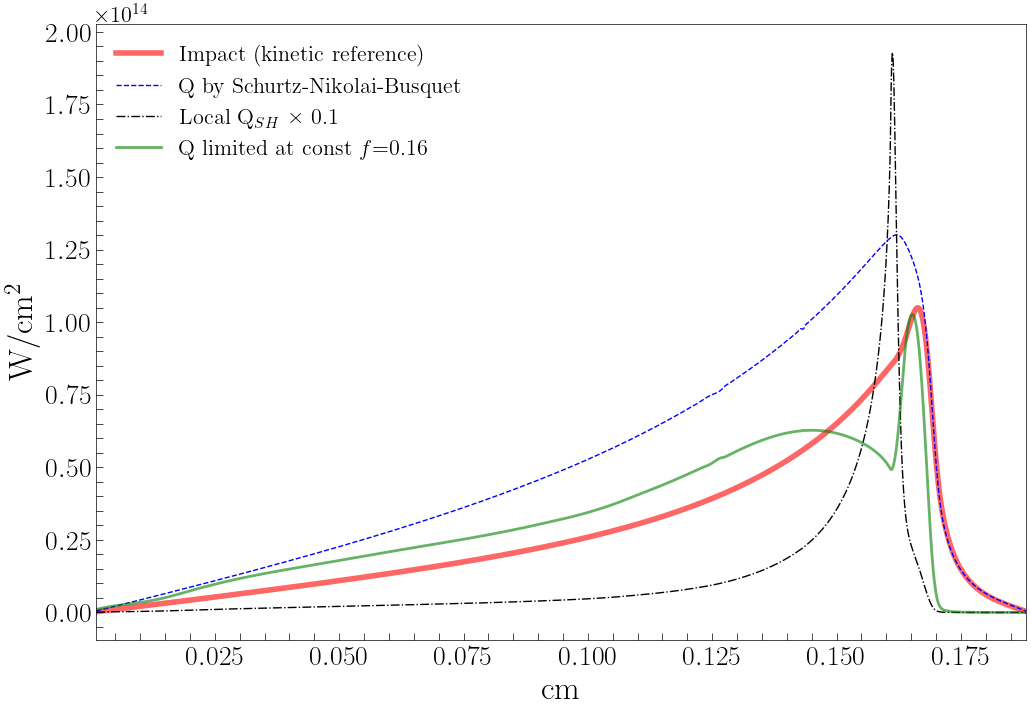

In [140]:
#!!!
def impdata(filename):
    url=f'https://raw.githubusercontent.com/homijan/ML-student-projects/intro-ab/students/bogdaale/gd-profiles/{filename}'
    return url
#!!!

x_Te, Te = np.loadtxt(impdata('Te_gdhohlraum_cm_10ps_TekeV_interp.txt'), usecols=(0, 1), unpack=True)
x_ne, ne = np.loadtxt(impdata('ne_gdhohlraum_cm_ne1e20cm3_interp.txt'), usecols=(0, 1), unpack=True)
x_Zbar, Zbar = np.loadtxt(impdata('Zbar_gdhohlraum_cm_Z_interp.txt'), usecols=(0, 1), unpack=True)

x_Qloc, Qloc = np.loadtxt(impdata('Q_gdhohlraum_microns_10ps_LocalWcm2.txt'), usecols=(0, 1), unpack=True)
x_Qimpact, Qimpact = np.loadtxt(impdata('Q_gdhohlraum_microns_10ps_IMPACTWcm2.txt'), usecols=(0, 1), unpack=True)
x_Qsnb, Qsnb = np.loadtxt(impdata('Q_gdhohlraum_microns_10ps_separatedsnbWcm2.txt'), usecols=(0, 1), unpack=True)

x_Qc7bBGK, Qc7bBGK, Knx = np.loadtxt(impdata('Q_gdhohlraum_cm_10ps_c7b-bgk-Wcm2-clogCHIC.txt'), comments='#', delimiter=', ', usecols=(0, 8, 6), unpack=True)
x_Qc7bAWBS, Qc7bAWBS = np.loadtxt(impdata('Q_gdhohlraum_cm_10ps_c7b-awbs-Wcm2-clogCHIC.txt'), comments='#', delimiter=', ', usecols=(0, 8), unpack=True)

# changing units um->cm
x_Qloc/=1e4
x_Qimpact/=1e4
x_Qsnb/=1e4

def getsub(f, x, xref):
    f_cs = CubicSpline(x, f)
    return f_cs(xref)

def Qstream(ne, Te):
    me = 9.1094e-28 # [g]
    eV2K = 1.1604e4 # K = eV2K * eV
    erg2J = 1e-7
    kB = 1.3807e-16 * eV2K # [erg/eV]
  # Local thermal energy density
    eTh = ne * kB * Te
  # Thermal velocity
    vTh = (kB * Te / me)**0.5
  # Free-streaming heat flux [cm/s*erg/cm3]
    Qfs = vTh * eTh
    return erg2J * Qfs

# Transform data to match given spatial interval 
# Default values spanning the whole c7b spatial domain
xmin = -1.0; xmax = 1.0


xref = x_Te[np.logical_and(x_Te > xmin, x_Te < xmax)]
Te = getsub(Te, x_Te, xref)
ne = getsub(ne, x_ne, xref)
Zbar = getsub(Zbar, x_Zbar, xref)
Qloc = getsub(Qloc, x_Qloc, xref)
Qimpact = getsub(Qimpact, x_Qimpact, xref)
Qsnb = getsub(Qsnb, x_Qsnb, xref)
Qc7bBGK = getsub(Qc7bBGK, x_Qc7bBGK, xref)
Knx = getsub(Knx, x_Qc7bBGK, xref)
Qc7bAWBS = getsub(Qc7bAWBS, x_Qc7bAWBS, xref)

#calculating Te gradient
gradTe=np.gradient(Te, xref)

# Evaluate free-streaming heat flux
Qfs = Qstream(ne, Te)

# Evaluate effective heat flux (logistic weighting of Qloc and Qfs) 
def fitQeff(X, flim):
    #fit function for Qloc profile
    ne, Z, Te, gradTe = X
    kQSH = 6.1e+02 # scaling constant corresponding to the SHICK local heat flux
    Qloc = -(kQSH/Z)*((Z+0.24)/(Z+4.2))*Te**2.5*gradTe
    Qfs = Qstream(ne, Te)
    Qeff = flim * Qfs * (1.0 - np.exp(-Qloc/(flim*Qfs)))
    return Qeff
par3, cov3 = curve_fit(fitQeff, (ne, Zbar, Te, gradTe), Qimpact,  maxfev = 1000)
standev3=np.sqrt(np.diag(cov3))
flim = par3[0]
print(f'Flux limiter from Qeff profile flim = {flim:.1e} ± {standev3[0]:.1e}')

if (len(sys.argv) > 3):
    flim = float(sys.argv[3])
    print(f'Flux limiter overruled to flim = {flim}')
    
#plot stuff
fontsize = 16
plt.rcParams.update({'font.size': fontsize})

strflim = f'{flim:.2f}'
fig1, axs1 = plt.subplots(1, 1, figsize=(12, 8))
axs1.plot(xref, Qimpact, color='red', label="Impact (kinetic reference)", linewidth=4.0, alpha=0.6)
# TODO: Use real NN-driven heat flux Q
QNN = Qimpact
axs1.plot(xref, Qsnb, 'b--', label="Q by Schurtz-Nikolai-Busquet")
axs1.plot(xref, 0.1*Qloc, 'k-.', label=r'Local Q$_{SH}$ × 0.1')
axs1.plot(xref, fitQeff((ne, Zbar, Te, gradTe), flim), 'green', label=f'Q limited at const $f$={strflim}', lw=2, alpha=0.6)
#axs1.plot(scaled_Qdata.index,plot_pred, 'red',label='NN Prediction', lw=2)
#axs1.plot(xref, flim*Qfs, ':', label=f'{strflim} free-streaming')
axs1.set_xlabel('cm', fontsize=24)
axs1.set_ylabel('W/cm$^2$', fontsize=24)
axs1.legend(loc="upper left")
axs1.autoscale(enable=True, axis='x', tight=True)
axs1.tick_params(axis='x',which='both',bottom=True,top=False,labelbottom=True, labelsize=20, size=5)
axs1.tick_params(axis='y',which='both',left=True,right=False, labelsize=20, size=5)

plt.show()

In [141]:
gradQimpact=np.gradient(Qimpact, xref)
gradQsnb=np.gradient(Qsnb, xref)
gradQloc=np.gradient(Qloc, xref)
gradfitQeff=np.gradient(fitQeff((ne, Zbar, Te, gradTe), flim), xref)

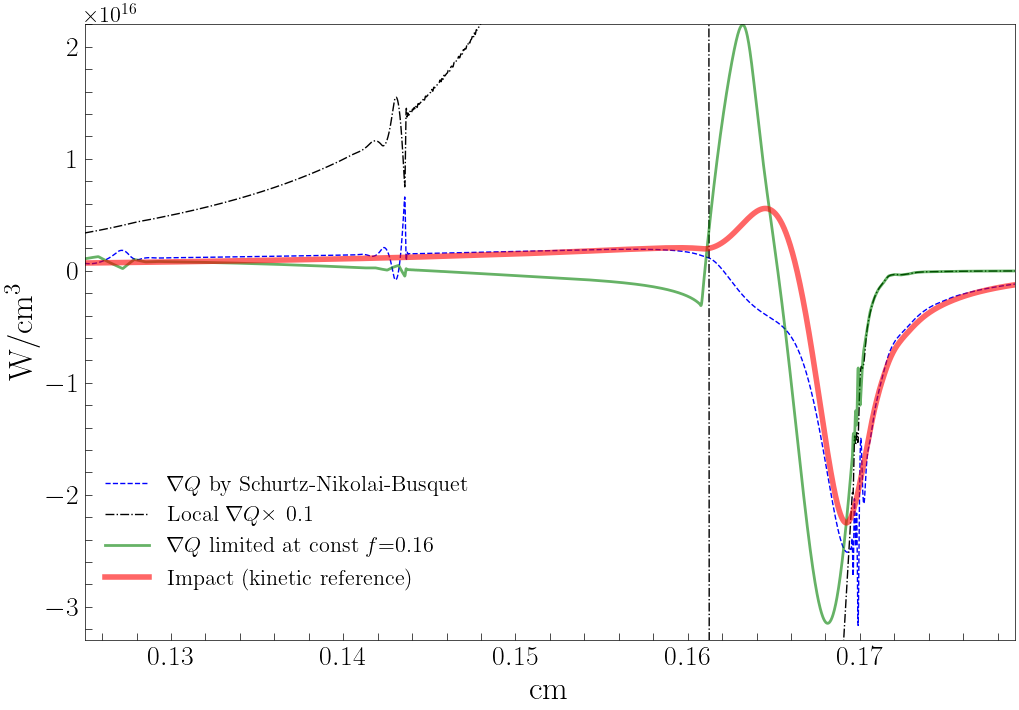

In [142]:
fig2, axs2 = plt.subplots(figsize=(12, 8))

#axs2.plot(scaled_Qdata.index,gradQpred, 'r', label=r'$\nabla Q$ NN prediction', lw=2)

axs2.plot(xref,gradQsnb,'b--', label=r'$\nabla Q$  by Schurtz-Nikolai-Busquet')
axs2.plot(xref,gradQloc,'k-.', label=r'Local $\nabla  Q$× 0.1')
axs2.plot(xref,gradfitQeff, 'g', label=r'$\nabla Q$ limited at const $f$=0.16', lw=2, alpha=0.6)
axs2.plot(scaled_Qdata.index,gradQact,'red', label=r'Impact (kinetic reference)', linewidth=4.0, alpha=0.6)
axs2.set_ylim(-3.3e16,2.2e16)
axs2.set_xlim(0.125,0.179)
axs2.set_xlabel('cm', fontsize=24)
axs2.set_ylabel('W/cm$^3$', fontsize=24)
axs2.legend(loc="upper left", bbox_to_anchor=(0, 0.3))
axs2.tick_params(axis='x',which='both',bottom=True,top=False,labelbottom=True, labelsize=20, size=5)
axs2.tick_params(axis='y',which='both',left=True,right=False, labelsize=20, size=5)
#axs2.autoscale(enable=True, axis='x', tight=True)



In [156]:
!python -m torch.utils.collect_env

PyTorch version: 1.13.0
Is debug build: False
CUDA used to build PyTorch: Could not collect
ROCM used to build PyTorch: N/A

OS: Microsoft Windows 10 Pro
GCC version: Could not collect
Clang version: Could not collect
CMake version: Could not collect
Libc version: N/A

Python version: 3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)] (64-bit runtime)
Python platform: Windows-10-10.0.19045-SP0
Is CUDA available: False
CUDA runtime version: Could not collect
CUDA_MODULE_LOADING set to: N/A
GPU models and configuration: GPU 0: NVIDIA GeForce GTX 1650
Nvidia driver version: 512.78
cuDNN version: Could not collect
HIP runtime version: N/A
MIOpen runtime version: N/A
Is XNNPACK available: True

Versions of relevant libraries:
[pip3] mypy-extensions==0.4.3
[pip3] numpy==1.22.3
[pip3] numpydoc==1.5.0
[pip3] pytorch-lightning==1.7.7
[pip3] torch==1.13.0
[pip3] torchaudio==0.13.0
[pip3] torchmetrics==0.10.3
[pip3] torchvision==0.14.0
[conda] blas                      1.0          

In [157]:
print(torch.cuda.is_available())

False
